In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !pip install imutils
# !pip install efficientnet

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
skinDf=pd.read_csv('/content/drive/MyDrive/CS 445/archive/HAM10000_metadata.csv')
skinDf

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


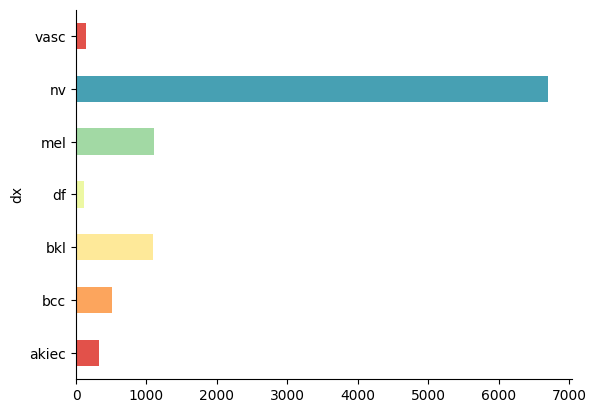

In [ ]:
skinDf.groupby('dx').size().plot(kind='barh', color=sns.palettes.mpl_palette('Spectral'))
plt.gca().spines[['top', 'right',]].set_visible(False)

<ipython-input-10-549ed8c9bfb8>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=grouped_data.index, x=grouped_data.values, palette='pastel')


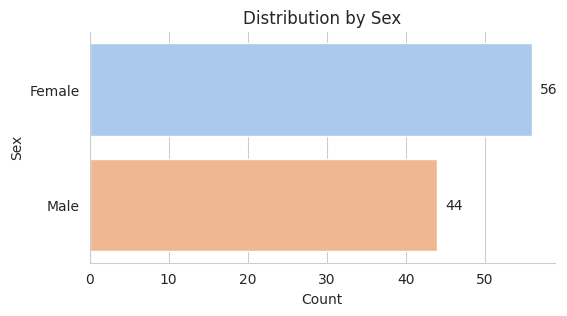

In [ ]:
np.random.seed(0)
data = {'sex': np.random.choice(['Male', 'Female'], size=100)}
sex_df = pd.DataFrame(data)

grouped_data = sex_df.groupby('sex').size()

sns.set_style("whitegrid")
plt.figure(figsize=(6, 3))
ax = sns.barplot(y=grouped_data.index, x=grouped_data.values, palette='pastel')

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 1, p.get_y() + p.get_height()/2.,
             f'{int(width)}', va='center')

plt.xlabel('Count')
plt.ylabel('Sex')
plt.title('Distribution by Sex')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

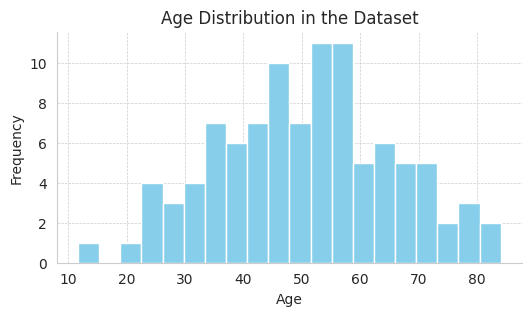

In [ ]:
np.random.seed(0)
data = {'age': np.random.normal(50, 15, size=100)}
age_data = pd.DataFrame(data)

plt.figure(figsize=(6, 3))
ax = plt.gca()
age_data['age'].plot(kind='hist', bins=20, color='skyblue', edgecolor='white', title='Age Distribution')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution in the Dataset')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Model Part

In [ ]:
import os
from glob import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

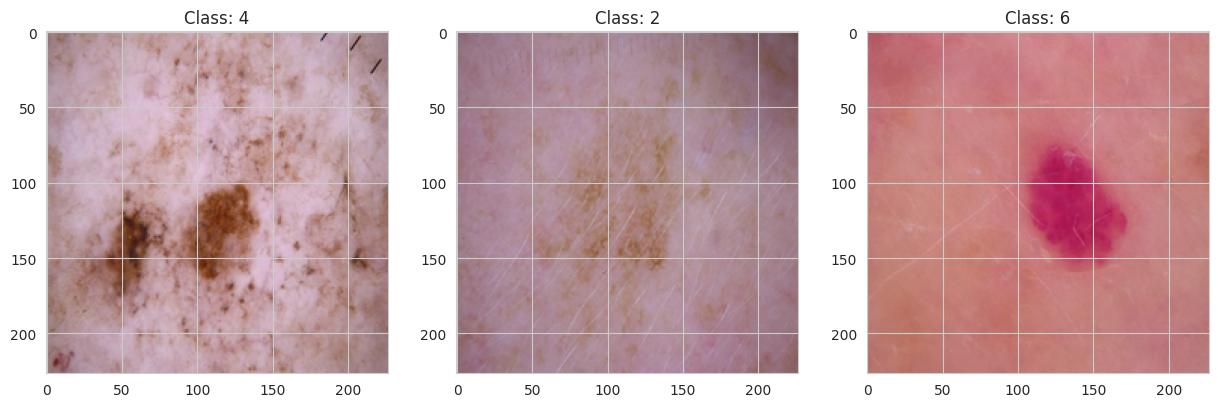

In [ ]:
labelEncoder = LabelEncoder()
skinDf['label'] = labelEncoder.fit_transform(skinDf['dx'])

n_samples = 800
dfs_by_label_resampled = {}
for label in range(7):
    df_label_resampled = resample(skinDf[skinDf['label'] == label], n_samples=n_samples, replace=True, random_state=42)
    dfs_by_label_resampled[label] = df_label_resampled

balanced_df = pd.concat(dfs_by_label_resampled.values())
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

base_path = '/content/drive/MyDrive/CS 445/archive/HAM10000_images_part_1/'
imgPath = {os.path.splitext(os.path.basename(x))[0]: x
           for x in glob(os.path.join(base_path, '*.jpg'))}

def fetch_image(image_id):
    path = imgPath.get(image_id)
    if path:
        with Image.open(path) as img:
            return np.asarray(img.resize((227, 227)))

balanced_df['image'] = balanced_df['image_id'].map(fetch_image)
balanced_df = balanced_df.dropna(subset=['image'])

x = np.asarray(balanced_df['image'].tolist())
x = x / 255.0

y = to_categorical(balanced_df['label'], num_classes=7)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].imshow(x_train[i])
    axs[i].title.set_text(f"Class: {np.argmax(y_train[i])}")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = tf.keras.models.Sequential([

    Conv2D(48, kernel_size=(11, 11), strides=(4, 4), padding='valid', activation='relu', input_shape=(227, 227, 3)),

    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    Conv2D(192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),
    Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'),

    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'),

    Flatten(),

    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 48)        17472     
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 48)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 128)       153728    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 192)       221376    
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 192)       3

In [ ]:
history = model.fit(x_train, y_train, epochs=90, batch_size=64, validation_split=0.2)

Epoch 1/90
28/28 [==============================] - 11s 134ms/step - loss: 4.4598 - accuracy: 0.1505 - val_loss: 4.2700 - val_accuracy: 0.1409
Epoch 2/90
28/28 [==============================] - 1s 40ms/step - loss: 4.1148 - accuracy: 0.1712 - val_loss: 3.9512 - val_accuracy: 0.1409
Epoch 3/90
28/28 [==============================] - 1s 40ms/step - loss: 3.8046 - accuracy: 0.2071 - val_loss: 3.6157 - val_accuracy: 0.2617
Epoch 4/90
28/28 [==============================] - 1s 40ms/step - loss: 3.5329 - accuracy: 0.2401 - val_loss: 3.3691 - val_accuracy: 0.2349
Epoch 5/90
28/28 [==============================] - 1s 40ms/step - loss: 3.2668 - accuracy: 0.2636 - val_loss: 3.1113 - val_accuracy: 0.2953
Epoch 6/90
28/28 [==============================] - 1s 40ms/step - loss: 3.1098 - accuracy: 0.2764 - val_loss: 2.9636 - val_accuracy: 0.3020
Epoch 7/90
28/28 [==============================] - 1s 40ms/step - loss: 2.9294 - accuracy: 0.3033 - val_loss: 2.7476 - val_accuracy: 0.3826
Epoch 8/90


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test Accuracy: {test_acc*100:.2f}%")

18/18 - 1s - loss: 1.4143 - accuracy: 0.8175 - 817ms/epoch - 45ms/step
Test Accuracy: 81.75%


In [ ]:
model.save('/content/drive/MyDrive/CS 445/my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


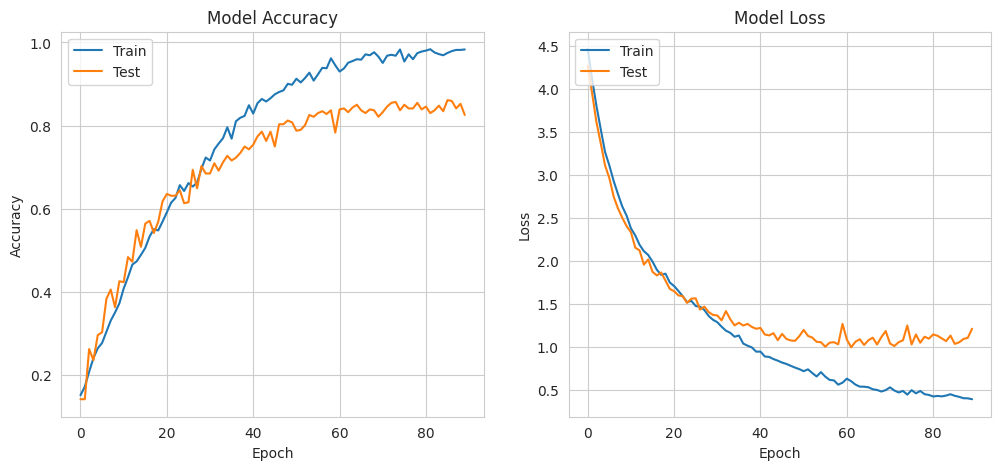

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
